<a href="https://colab.research.google.com/github/kmotohas/dl4practitioners/blob/master/notebooks/joki.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第3章 ハンズオンで学ぶ文書分類モデルの作成とツールの利用方法（仮）

本章では文書分類モデルの作成を通じて自然言語処理で用いられる数々のPythonツールの利用方法を学びます。データの準備、形態素解析、正規化などの前処理、機械学習モデルの訓練、そして評価という一連の流れを体験しましょう。

なお、動作確認は以下の環境で行いました。

- Machine (AWS EC2 p2.xlargeインスタンス)
    - OS: Ubuntu 16.04
    - CPU: Intel(R) Xeon(R) CPU E5-2686 v4 @ 2.30GHz
    - RAM: 64GB 
    - GPU: NVIDIA Tesla K80
- Python
    - python: 3.7.5
    - mecab-python3: 0.996.2
    - torch (PyTorch): 1.3.1
    - torchtext: 0.4.0
    - transformers 2.3.0
    - spaCy 2.2.3
    - cupy 7.0.0
    


## 3.1 機械学習モデル開発のワークフローと本章で扱う内容

文書分類のモデルは基本的に**教師あり学習**の枠組みで訓練します。つまり、図のようにテキストとラベルのペアで訓練データを用意します。例えばニュース記事があるとして、その記事はスポーツニュースなのか、芸能ニュースなのか、政治ニュースなのかを記事内の文章から分類したいとします。このときニュース記事の文章と、分類すべきカテゴリーの名前をペアとして扱います。

![training](https://github.com/kmotohas/dl4practitioners/blob/master/notebooks/figures/training.png?raw=1)
<center>機械学習モデル開発のワークフロー (図出典: https://spacy.io/usage/training)</center>

大まかにいうと大体以下の様な流れに沿って機械学習モデルの学習を進めていきます。

1. 訓練用のデータセットを用意する
2. 分類に用いる機械学習モデルを準備する
3. モデルに訓練データのテキストを入力して予測値を得る
4. モデルの予測と真のラベルを比較する
5. 誤差を減らすようなモデルのパラメーター (重み) の更新値 (gradient) を計算する
6. モデルのパラメーターを更新する
7. 3から6を繰り返す

具体的な手順に関しては次の節以降で見ていきましょう。



## 3.2 文書分類ハンズオン

ここではExplosion AIが開発する汎用的な自然言語処理ツールである **spaCy** と、Hugging Faceが開発するtransformerベースの現在最先端のモデルを簡単に利用するためのツールである **transformers** を扱ってニュース記事の分類モデルを作成します。



### 3.2.1 本章で扱う主な自然言語処理ツールの解説



#### 3.2.1.1 spaCy

spaCy (https://spacy.io/) とはExplosion AIにより開発されている自然言語処理用のライブラリです。spaCyには事前学習済みの統計モデルと単語ベクトルが付属しており、50以上の言語の形態素解析（トークン化）がサポートされています。また、品詞タグ付け、依存関係解析、固有表現抽出、およびテキスト分類のための単語バッグや簡単な畳み込みニューラルネットワークモデルも備えています。MITライセンスの下でリリースされた商用のオープンソースソフトウェアです。

spaCyのドキュメンテーション (https://spacy.io/usage/) に従ってインストールしてみましょう。環境によってインストールコマンドが異なるので適宜ドキュメンテーションを参考にしてください。ここではGPU付きのオプションでインストールします。

In [0]:
!pip install -U spacy[cuda]
# pip install -U spacy  # GPUを利用しない場合

spaCyと同時に、Explosion AIにより開発されているThinc (https://github.com/explosion/thinc) という機械学習ライブラリや、Preferred NetworksのCUDA対応のNumPy互換行列計算ライブラリであるCuPy (https://cupy.chainer.org/) などがインストールされます。

日本語の形態素解析ツールのMeCab (http://taku910.github.io/mecab/) もインストールしましょう。

In [0]:
!pip install mecab-python3

分かち書きのテストをしてみましょう。

In [0]:
import spacy
nlp = spacy.blank('ja')
for word in nlp('すもももももももものうち'):
    print(word)

すもも
も
もも
も
もも
の
うち


うまく単語ごとに分割してくれていますね。本章でのスコープからは外れますが、リクルートと国立国語研究所が開発した GiNZAをインストールするとspaCy経由で日本語文章の解析処理を簡単に行うことができます。

In [3]:
!pip install -U ginza

     |████████████████████████████████| 54.9MB 84kB/s 
     |████████████████████████████████| 44.8MB 67kB/s 
  Created wheel for ginza: filename=ginza-3.1.1-cp36-none-any.whl size=17307 sha256=bf30f648733be3dff719b3675ce6b51aca9e2a3272109f3fba3f7e1efda5a47b
  Stored in directory: /root/.cache/pip/wheels/cc/18/14/2bf82ef108dd1c793f80c0dd75cc8599eca857f641b0fe1149
  Created wheel for ja-ginza: filename=ja_ginza-3.1.0-cp36-none-any.whl size=54963618 sha256=5da68c3a00759fd5348c10003dc9eacad58e5aede4917552b8ce221f68fda6dd
  Stored in directory: /root/.cache/pip/wheels/f2/8a/07/1837eeb5c5648fa8d266102b78a894e495234585ac3f024cf1
  Created wheel for ja-ginza-dict: filename=ja_ginza_dict-3.1.0-cp36-none-any.whl size=70877547 sha256=6c94fe8cb9082b4d344dd179a0cf05d6fc8da22ad1438a86e3576170e32c0762
  Stored in directory: /root/.cache/pip/wheels/30/88/d7/7f0692ba26060966af34538e1079438d16640c54e04a15a76a
Successfully built ginza ja-ginza ja-ginza-dict
  Found existing installation: ja-ginza 2.2.0


GiNZAのモデルを利用すると品詞タグ付けのみならず、トークン間の依存関係ラベリングや固有表現抽出などを行うことができます。ここではトークン間の依存関係を図示する例を示します。

In [6]:
import spacy
from spacy import displacy
nlp = spacy.load('ja_ginza')
doc = nlp('すもももももももものうち')
displacy.render(doc, style="dep", options={"compact":True})

'<svg xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" xml:lang="ja" id="c1344fb973b340b19fbc38e9ed4b50b7-0" class="displacy" width="1100" height="362.0" direction="ltr" style="max-width: none; height: 362.0px; color: #000000; background: #ffffff; font-family: Arial; direction: ltr">\n<text class="displacy-token" fill="currentColor" text-anchor="middle" y="272.0">\n    <tspan class="displacy-word" fill="currentColor" x="50">すもも</tspan>\n    <tspan class="displacy-tag" dy="2em" fill="currentColor" x="50">NOUN</tspan>\n</text>\n\n<text class="displacy-token" fill="currentColor" text-anchor="middle" y="272.0">\n    <tspan class="displacy-word" fill="currentColor" x="200">も</tspan>\n    <tspan class="displacy-tag" dy="2em" fill="currentColor" x="200">ADP</tspan>\n</text>\n\n<text class="displacy-token" fill="currentColor" text-anchor="middle" y="272.0">\n    <tspan class="displacy-word" fill="currentColor" x="350">もも</tspan>\n    <tspan class="displacy-tag" dy=

GiNZAとspaCyに関してはオージス総研グループによる「はじめての自然言語処理　第4回 spaCy/GiNZA を用いた自然言語処理」 (https://www.ogis-ri.co.jp/otc/hiroba/technical/similar-document-search/part4.html) に詳しい解説がありますのでそちらを参照することをお勧めします。

#### 3.2.1.2 Transformers

Transformersはtransformerベースの汎用アーキテクチャ （BERT、GPT-2、RoBERTa、XLM、DistilBert、XLNet、CTRL、...） を利用するためのオープンソースのシンプルなAPIを提供しています。開発はHugging Faceにより行われており、100以上の言語に対応した事前学習済みモデルが公開されています。ディープラーニングフレームワークとしてはGoogleのTensorFlow 2.0およびFaceBookが開発しているPyTorchに対応しています。ここではPyTorchを用いることにします。

Transformersで用いることのできるモデルのリストはHugging Faceのホームページ (https://huggingface.co/models) にて公開されています。日本語用BERTモデルとしては、執筆時点 (2019年12月) では東北大学 乾・鈴木研究室が公開している以下の4つのモデルを利用可能です。

-  `bert-base-japanese`:
-  `bert-base-japanese-whole-word-masking`
-  `bert-base-japanese-char`
-  `bert-base-japanese-char-whole-word-masking`

BERTには大きく分けて `BERT-Base` (12-layer, 768-hidden, 12-heads, 110M parameters) と `BERT-Large` (24-layer, 1024-hidden, 16-heads, 340M parameters) のふたつのアーキテクチャーがあります。上記のモデルは `BERT-Base` を日本語のWikipediaのデータを用いて訓練したものです。`bert-base-japanese` はMeCabとWordPieceと呼ばれる手法を用いてテキストの分かち書きを行った後に訓練されたものであり、`bert-base-japanese-char` ではテキストを文字ごとに分割しています。

BERTの訓練時に行うタスクのひとつに、文章内のトークンをマスクし、そのトークンを予測する、というものがあります。例えば `"He likes playing the piano."` という文章を `"He likes [MASK] ##ing the piano."` という文章に変換し、`[MASK]` に含まれるトークンを予測します。なお、`##` から始まるトークンは接尾辞を表しています。このとき、単語に対応するトークンはまとめてマスクするのが Whole Word Masking と呼ばれる手法です。先ほどの文章を `"He likes [MASK] [MASK] the piano."` のようにマスクして訓練したモデルが `bert-base-japanese-whole-word-masking` および、`bert-base-japanese-char-whole-word-masking` です。

さて、transformersをインストールしてみましょう。環境によってインストールコマンドが異なります。https://pytorch.org/get-started/ を参照してください。

In [0]:
# 2019年12月現在、NVIDIAのGPUを搭載したLinuxマシンにPyTorchをインストールするコマンドは以下の通りです。
!pip install torch torchvision

PyTorchで自然言語処理を行うときに便利なライブラリであるtorchtextもインストールしましょう。

In [0]:
!pip install torchtext

transformersのインストールもpipを用いて簡単に行えます。

In [0]:
!pip install transformers

また、以降で補助的に利用するライブラリもインストールしてください。

In [0]:
!pip install pandas scikit-learn mojimoji tensorboard

- pandas
- scikit-learn
- seaborn
- mojimoji

transformersの `BertJapaneseTokenizer` を用いた日本語文章の分かち書きのテストもしてみましょう。

In [0]:
from transformers import BertJapaneseTokenizer
tokenizer = BertJapaneseTokenizer.from_pretrained('bert-base-japanese-whole-word-masking')
tokenizer.tokenize('いつもプレゼンテーションの撮影に無音カメラアプリをご利用いただきありがとうございます。')

['いつも',
 'プレゼンテーション',
 'の',
 '撮影',
 'に',
 '無',
 '##音',
 'カメラ',
 '##アプリ',
 'を',
 'ご',
 '利用',
 'いただ',
 '##き',
 'ありがとう',
 'ござい',
 'ます',
 '。']

### 3.2.2 データセットの準備

次に機械学習モデルの訓練の要であるデータセットの準備をします。ここではlivedoor ニュースコーパスの各段落の文章を入力としてニュースサービスのカテゴリ名を判別するという問題設定でデータセットを作成します。



#### 3.2.2.1 livedoor ニュースコーパス

今回は日本語における自然言語処理の試験用データセットとしてしばしば用いられる「livedoor ニュースコーパス」を用います。

livedoorニュースはもともと株式会社ライブドアが運営するニュースサイトでしたが、株式会社ライブドアが旧ハンゲームジャパン株式会社であるNHN Japan株式会社に買収され、現在はNHN Japanが社名変更したLINE株式会社により運営されています。livedoorニュースの記事の一部には「クリエイティブ・コモンズライセンス『表示 – 改変禁止』」が適用されており、営利目的を含めて再配布可能となっています。該当するニュース記事を2012年9月上旬に株式会社ロンウイットが収集し、HTMLタグの除去などクリーニングを施した状態で公開しているのが「livedoor ニュースコーパス」です。

livedoor ニュースコーパスは以下のリンクよりダウンロード可能です。

https://www.rondhuit.com/download.html#ldcc

オープンソースの全文検索システムApache Solrで扱いやすいようXML形式でニュースが格納されている `livedoor-news-data.tar.gz` と、シンプルに各々のニュースをテキストファイルとして扱っている `ldcc-20140209.tar.gz` が公開されています。

今回は後者の `ldcc-20140209.tar.gz` をダウンロードしてください。`tar xzvf ldcc-20140209.tar.gz` などにより解凍すると `text` という名前のディレクトリが出てきます。以下のPythonスクリプトを実行するとコーパスのダウンロードと圧縮ファイルの解凍が行われ、カレントディレクトリに `text` ディレクトリが作成されます。

In [0]:
import os
import urllib.request
import tarfile

# dataディレクトリの作成
#os.makedirs('data', exist_ok=True)

url = 'https://www.rondhuit.com/download/ldcc-20140209.tar.gz'
file_name = 'ldcc-20140209.tar.gz'

# dataディレクトリへのlivedoor ニュースコーパスのダウンロードと解凍
if not os.path.exists(file_name):
    urllib.request.urlretrieve(url, file_name)
    # tar.gzファイルを読み込み
    with tarfile.open(file_name) as tar:
        tar.extractall()
    # tar.gzファイルを消去
    os.remove(file_name)

`text` ディレクトリの中身の構造は以下の通りです。

```
text
├── CHANGES.txt
├── README.txt
├── dokujo-tsushin
├── it-life-hack
├── kaden-channel
├── livedoor-homme
├── movie-enter
├── peachy
├── smax
├── sports-watch
└── topic-news
```

`dokujo-tsushin` から `topic-news` はディレクトリであり、それぞれにニュース記事のテキストが格納されています。先ほどのツリーの階層をひとつ深くしてみると以下の様になります。

```
text
├── CHANGES.txt
├── README.txt
├── dokujo-tsushin
│   ├── LICENSE.txt
│   ├── dokujo-tsushin-4778030.txt
│   ├── dokujo-tsushin-4778031.txt
│   ├── dokujo-tsushin-4782522.txt
...（以下略）
```

ニュース提供元は以下の9つです。記事の本文の各段落だけを見て、その記事がどのカテゴリに属しているのか（独女通信のニュースなのか、ITライフハックのニュースなのか、など）を判別する文書分類モデルを作成するのが本章の目的です。（記事の本文を全て一度に入力すると問題として簡単すぎるので、ここでは段落ごとに分割して独立した文章として扱っています。）

- 独女通信 (http://news.livedoor.com/category/vender/90/)
- ITライフハック (http://news.livedoor.com/category/vender/223/)
- 家電チャンネル (http://news.livedoor.com/category/vender/kadench/)
- livedoor HOMME (http://news.livedoor.com/category/vender/homme/)
- MOVIE ENTER (http://news.livedoor.com/category/vender/movie_enter/)
- Peachy (http://news.livedoor.com/category/vender/ldgirls/)
- エスマックス (http://news.livedoor.com/category/vender/smax/)
- Sports Watch (http://news.livedoor.com/category/vender/208/)
- トピックニュース (http://news.livedoor.com/category/vender/news/)

ちなみに、上記サービスのうちいくつかはドメインが変わっていたり終了しているので一部リンクが切れています。それぞれの記事ファイル（dokujo-tsushin-4778030.txtなど）は以下のフォーマットで構成されています。

- １行目: 記事のURL
- ２行目: 記事の日付
- ３行目: 記事のタイトル
- ４行目以降： 記事の本文

このままでは少し扱いづらいのでひとつのtsv (tab-separated values) にまとめます。次のスクリプトの実行には多少時間がかかります。私の環境では6分弱かかりました。

In [0]:
import os
import glob

import pandas as pd

# あまりに短い段落は除く
minimum_sentence_length = 32

# livedoor ニュースのサービス名のリスト
services = [
    'dokujo-tsushin',
    'it-life-hack',
    'kaden-channel',
    'livedoor-homme',
    'movie-enter',
    'peachy',
    'smax',
    'sports-watch',
    'topic-news'
]
# tsvファイルの各カラムのインデックス名のリスト
index = ['url', 'datetime', 'title', 'body']

# 空のPandasのDataFrameを準備
df = pd.DataFrame()

# 各サービスのディレクトリでループ
for service in services:
    print('===== processing {} ====='.format(service))
    # ニュース記事をすべて指定
    # パスの例は './text/dokujo-tsushin/dokujo-tsushin-4778030.txt'
    # LICENSE.txt は除外
    wild_card = os.path.join('text', service, service + '*.txt')
    file_paths = glob.glob(wild_card)
    # 各ニュース記事のファイルパスでループ
    for file_path in file_paths:
        # ファイルを開いて一行ずつ読み込む
        with open(file_path, 'r') as f:
            lines = f.readlines()
            # tsv のカラムを辞書型で用意
            series_dict = {'service': service}
            for num, line in enumerate(lines):
                #line = line.replace('\n', '')  # 改行を削除
                # 0, 1, 2行目はそれぞれURL, 日付, 記事タイトルに相当
                if num < len(index):
                    series_dict[index[num]] = line
                # 3行目以降は本文
                elif line != '\n' and line != '':
                    series_dict['body'] += line
                # lineが空（段落の境目もしくはファイルの末尾）の場合
                else:
                    if '関連記事' in series_dict['body']:
                        pass
                    elif '関連リンク' in series_dict['body']:
                        pass
                    # PandasのSeriesを作成し、DataFrameに追加していく
                    elif len(series_dict['body']) > minimum_sentence_length:
                        s = pd.Series(series_dict)
                        df = df.append(s, ignore_index=True)
                    # bodyを初期化
                    series_dict['body'] = ''
print('done')         

作成した `DataFrame` の最初の5行と最後の5行だけ抜き出して表示してみましょう。
それぞれの行がニュース記事のひとつの段落に対応しています。ニュース記事自体は計7367個ありますが、32文字以下の短い段落を除くと全部で56631個の段落がありことがわかります。

In [0]:
pd.concat([df.head(3), df.tail(3)])

,body,datetime,service,title,url
0,「しっかりメイクをしている顔よりも、スッピンのほうがいい」と言う男性は少なくない。しかしメイ...,2011-10-13T15:28:00+0900\n,dokujo-tsushin,「スッピンのほうがいい」って本当？——言葉の裏に隠された男の本音\n,http://news.livedoor.com/article/detail/593428...
1,「『スッピンのほうがいい』とは、スッピンでもメイク時と同じくらいかわいい女性が好みだという意...,2011-10-13T15:28:00+0900\n,dokujo-tsushin,「スッピンのほうがいい」って本当？——言葉の裏に隠された男の本音\n,http://news.livedoor.com/article/detail/593428...
2,●「女の子は多少、太ってるくらいがかわいいよ」\n女性は年中、ダイエットと向き合っている。ど...,2011-10-13T15:28:00+0900\n,dokujo-tsushin,「スッピンのほうがいい」って本当？——言葉の裏に隠された男の本音\n,http://news.livedoor.com/article/detail/593428...
56628,藤村修官房長官は20日、記者会見を開き、「政府として軍事転用などという考えは一切持っていない...,2012-06-21T20:32:00+0900\n,topic-news,原子力基本法の改正に、韓国から「日本の核武装を阻止すべき」「我々も核武装だ」の声\n,http://news.livedoor.com/article/detail/668154...
56629,ニュースを受け、韓国のネット掲示板では、「日本は本当に怖い国だ」「日本がするなら我々もする」...,2012-06-21T20:32:00+0900\n,topic-news,原子力基本法の改正に、韓国から「日本の核武装を阻止すべき」「我々も核武装だ」の声\n,http://news.livedoor.com/article/detail/668154...
56630,一方で、「韓国、日本、台湾が全部核武装すれば真の平和が訪れるかもしれない」「各国の健全な良識...,2012-06-21T20:32:00+0900\n,topic-news,原子力基本法の改正に、韓国から「日本の核武装を阻止すべき」「我々も核武装だ」の声\n,http://news.livedoor.com/article/detail/668154...


各サービスごとの段落数を数えるには `pandas.Series.value_counts()` メソッドを利用します。

In [0]:
df['service'].value_counts()

smax              9212
it-life-hack      8400
dokujo-tsushin    8296
peachy            7934
movie-enter       6524
livedoor-homme    5329
kaden-channel     3818
topic-news        3603
sports-watch      3515
Name: service, dtype: int64

`pandas.Series.plot` を利用してグラフを作成することも可能です。ここでは `kind='bar'` で棒グラフを指定し、横軸のラベルを見やすい様に `rot=45` で45度回転し、y軸の範囲を `ylim=(0, 10000)` で0から10000に指定しています。

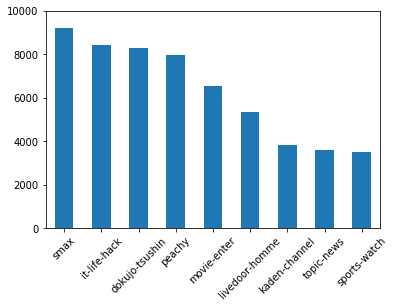

In [0]:
(df['service'].value_counts()).plot(kind='bar', rot=45, ylim=(0, 10000))

<center>各ニュースカテゴリーの段落データ数</center>

基本的にラベルは文字列のままでは扱いづらい（ことが多い）のでscikit-learnの `LabelEncoder` (`sklearn.preprocessing.LabelEncoder`) を用いて整数値に変換してあげます。処理後は `'dokujo-tsushin'` が `0` になり、`it-life-hack` が `1` になり、`kaden-channel` が `2` …といった様に変換されます。

In [0]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['service'] = le.fit_transform(df.service.values)
pd.concat([df.head(3), df.tail(3)])  # 最初と最後の3行を抽出

,body,datetime,service,title,url
0,「しっかりメイクをしている顔よりも、スッピンのほうがいい」と言う男性は少なくない。しかしメイ...,2011-10-13T15:28:00+0900\n,0,「スッピンのほうがいい」って本当？——言葉の裏に隠された男の本音\n,http://news.livedoor.com/article/detail/593428...
1,「『スッピンのほうがいい』とは、スッピンでもメイク時と同じくらいかわいい女性が好みだという意...,2011-10-13T15:28:00+0900\n,0,「スッピンのほうがいい」って本当？——言葉の裏に隠された男の本音\n,http://news.livedoor.com/article/detail/593428...
2,●「女の子は多少、太ってるくらいがかわいいよ」\n女性は年中、ダイエットと向き合っている。ど...,2011-10-13T15:28:00+0900\n,0,「スッピンのほうがいい」って本当？——言葉の裏に隠された男の本音\n,http://news.livedoor.com/article/detail/593428...
56628,藤村修官房長官は20日、記者会見を開き、「政府として軍事転用などという考えは一切持っていない...,2012-06-21T20:32:00+0900\n,8,原子力基本法の改正に、韓国から「日本の核武装を阻止すべき」「我々も核武装だ」の声\n,http://news.livedoor.com/article/detail/668154...
56629,ニュースを受け、韓国のネット掲示板では、「日本は本当に怖い国だ」「日本がするなら我々もする」...,2012-06-21T20:32:00+0900\n,8,原子力基本法の改正に、韓国から「日本の核武装を阻止すべき」「我々も核武装だ」の声\n,http://news.livedoor.com/article/detail/668154...
56630,一方で、「韓国、日本、台湾が全部核武装すれば真の平和が訪れるかもしれない」「各国の健全な良識...,2012-06-21T20:32:00+0900\n,8,原子力基本法の改正に、韓国から「日本の核武装を阻止すべき」「我々も核武装だ」の声\n,http://news.livedoor.com/article/detail/668154...


`service` の列が文字列でなく非負の整数値になっていることに注目してください。
ここで、scikit-learnの `train_test_split` (`sklearn.model_selection.train_test_split`) を用いてデータセットを「訓練データ」、「バリデーションデータ」、「テストデータ」に分割します。それぞれの役割は以下の通りです。

- 訓練データ: 機械学習モデルの重みの更新に利用する学習データ
- バリデーションデータ: 機械学習モデルの学習状況やハイパーパラメーターチューニングの良し悪しのチェックに用いるデータ
- テストデータ: 最終的に機械学習モデルの性能評価に用いるデータ

![holdout.png](https://github.com/kmotohas/dl4practitioners/blob/master/notebooks/figures/holdout.png?raw=1)
<center>ホールドアウト法によるデータセットの分割</center>

実際の学習は訓練データのみを用います。他ふたつはあくまで性能評価のために用います。本章ではハイパーパラメーターチューニングは行いませんが、形式的にこの通り分割することにします。それぞれのデータ量の割合は適当に8:1:1としました。

In [0]:
from sklearn.model_selection import train_test_split
df = df[['body', 'service']]  # 本文とラベルのみ抽出
train_df, val_test_df = train_test_split(df, test_size=0.2)
val_df, test_df = train_test_split(val_test_df, test_size=0.5)

`DataFrame` をCSV (Comma-Separated Value) やTSV (Tab-Separated Value) で保存するには `pandas.DataFrame.to_csv` メソッドを呼び出します。ひとつ目の引数 `path_or_buf` には保存先のファイルパス（もしくはファイルオブジェクト）を指定し、ふたつ目の引数 `sep` には列のセパレーターを指定します。デフォルトでは `sep=','` となっており、セパレーターはカンマ、つまり `DataFrame` はCSVで保存されます。自然言語処理を行う場合、データ内にカンマが含まれていることがあるのでしばしばセパレーターとしてはタブ (`\t`) が用いられます。ここでは `DataFrame` をTSVの形式で保存します。

デフォルトでは `index` 引数は `True` になっています。そのままにするとTSVファイルに行番号の数値（この場合0から56630）がひとつのカラムとして追加されます。必要ないので `index=False` としておきます。

In [0]:
train_df.to_csv('train.tsv', sep='\t', index=False)
val_df.to_csv('val.tsv', sep='\t', index=False)
test_df.to_csv('test.tsv', sep='\t', index=False)

これでデータセットを分割してTSVファイルとして保存できました。

### 3.2.3 文書分類モデル

ここでは単語バッグ、シンプルなCNN、そしてBERTをそれぞれ用いて文書分類を行ってみます。単語バッグとCNNのモデルはspaCyのAPIから利用できます。BERTはtransformersから利用します。訓練状況のモニタリングにはTensorBoardを用います。


#### 3.2.3.1 単語バッグ  (bag-of-words)

単語バッグとはデータセットのテキスト中の単語のヒストグラムのことです。つまり、それぞれの単語の出現数を特徴量として扱います。例えば "how does it feel like to wake up in the sun", "how does it feel like to shine on everyone" というふたつの文があったとします。この中の単語 (トークン) それぞれに番号を付けると例えば以下の様になります。

`{0: 'how', 1: 'does', 2: 'it', 3: 'feel', 4: 'like', 5: 'to', 6: 'wake', 7: 'up', 8: 'in', 9: 'the', 10: 'sun', 11: 'shine', 12: 'on', 13: 'everyone'}` 

それぞれの文を単語バッグとして表現すると以下の様になります。トークンの番号に対応するインデックスにそのトークンの出現数を詰めたリストとも言えます。

`[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]`

`[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1]`

単語バッグを用いればテキストを、データセットに出現するトークン数だけ次元がある（この場合は14次元の）ベクトルとみなすことができます。トークンひとつごとに番号を割り当てるのではなく、連続するトークンの対や三つ組など複数個をひとまとめに扱う手法を **n-グラム (n-gram)** と呼びます。spaCyの単語バッグはデフォルトでは `ngram_size=1` となっています。

##### データセットの読み込み

保存したTSVファイルを再度読み込む際には `read_csv` メソッドを利用します。

In [0]:
import pandas as pd
df_train = pd.read_csv('train.tsv', delimiter='\t')
df_val = pd.read_csv('val.tsv', delimiter='\t')
df_test = pd.read_csv('test.tsv', delimiter='\t')

Pandasの `DataFrame` ではドット演算子を利用して任意のカラムを取り出すことができます。ここではニュース本文を表すインデックスは `body` なので、`df.body` のようにして文章部分のみ抽出します。

In [0]:
train_texts = df_train.body
val_texts = df_val.body
test_texts = df_test.body

ニュース文章を分かち書きします。私の環境ではそれぞれ30秒、4秒、3秒ほどかかりました。

In [0]:
import spacy
spacy.prefer_gpu()  # GPUがない場合、この行はスキップ
nlp = spacy.blank('ja')

train_docs = list(nlp.pipe(train_texts))
val_docs = list(nlp.pipe(val_texts))
test_docs = list(nlp.pipe(test_texts))

spaCyのAPIに合わせて正解ラベルを整形してあげましょう。訓練時に用いる `spacy.Language.update` メソッドはラベルデータを辞書型のリストとして受け取るのですが、キーに `'words', 'tags', 'heads', 'deps', 'entities', 'cats', 'links'` のどれかが存在することを前提としています。文書分類の場合は `'cats'` が必要です。猫ではなく、カテゴリーの略です。それぞれのデータに対するラベルは以下の様な構成であることが求められています。キー `'cats'` の値がまた辞書型で、分類すべきラベルのキーの値のみ `True` で他は `False` となります。

```
[
"""データ#0"""
 {'cats': {'dokujo-tsushin': True,
           'it-life-hack': False,
           'kaden-channel': False,
           'livedoor-homme': False,
           'movie-enter': False,
           'peachy': False,
           'smax': False,
           'sports-watch': False,
           'topic-news': False}},
"""データ#1"""
 {'cats': {'dokujo-tsushin': False,
           'it-life-hack': True,
           'kaden-channel': False,
           'livedoor-homme': False,
           'movie-enter': False,
           'peachy': False,
           'smax': False,
           'sports-watch': False,
           'topic-news': False}},
"""データ#2以降"""
...]
```

リスト内包表記と辞書内包表記を併用していてやや見づらいですが、以下の様にして `DataFrame` に対してループを回して整形します。

In [0]:
services = [
    'dokujo-tsushin',
    'it-life-hack',
    'kaden-channel',
    'livedoor-homme',
    'movie-enter',
    'peachy',
    'smax',
    'sports-watch',
    'topic-news'
]

train_cats = [{'cats': {service: service == services[idx] for service in services}}
              for idx in df_train.service]
val_cats = [{'cats': {service: service == services[idx] for service in services}}
            for idx in df_val.service]
test_cats = [{'cats': {service: service == services[idx] for service in services}}
             for idx in df_test.service]

ちゃんと期待通りに整形できているか確かめます。

In [0]:
print(train_cats[0:2])

[{'cats': {'dokujo-tsushin': False, 'it-life-hack': False, 'kaden-channel': False, 'livedoor-homme': True, 'movie-enter': False, 'peachy': False, 'smax': False, 'sports-watch': False, 'topic-news': False}}, {'cats': {'dokujo-tsushin': False, 'it-life-hack': False, 'kaden-channel': False, 'livedoor-homme': False, 'movie-enter': False, 'peachy': False, 'smax': True, 'sports-watch': False, 'topic-news': False}}]


問題なければテキストとラベルのペアをリストに詰めます。

In [0]:
train_data = list(zip(train_docs, train_cats))
val_data = list(zip(val_docs, val_cats))
test_data = list(zip(test_docs, test_cats))

ここまででspaCyで文書分類を行うときのデータセットの準備は完了です。

##### 文書分類モデルの訓練


spaCyには自然言語処理のシーケンスとしてパイプラインという概念があります。

![pipeline.png](https://github.com/kmotohas/dl4practitioners/blob/master/notebooks/figures/pipeline.png?raw=1)
<center>spaCyのパイプラインの概念図 (図出典: https://spacy.io/usage/processing-pipelines)</center>

なお、前述のGiNZAのモデルを用いるとトークナイザーによる分かち書きだけでなく、品詞タグ付け、固有表現抽出、依存関係解析などの処理がパイプラインに含まれます。ここでは `nlp = spacy.blank('ja')` としてトークナイザー (MeCab) の処理のみ持ったパイプラインを指定しています。以下でパイプラインに文書分類モデルを `textcat` という名前で追加します。


In [0]:
if 'textcat' not in nlp.pipe_names:
    textcat = nlp.create_pipe('textcat', 
                              config={'exclusive_classes': True, 'architecture': 'bow'})
    nlp.add_pipe(textcat, last=True)  # パイプラインの末尾に追加

`'exclusive_classes': True` と指定するとモデルの出力層にソフトマックスが用いられます。つまり、モデルの出力がそれぞれのラベルに分類される確率として解釈できる様になります。なお、`'exclusive_classes': False` と指定すると出力層にはロジスティック関数が用いられます。排他的に分類するのではなく例えば、ニュース記事の分類時にこれはスポーツかつゴシップである、といった様に複数ラベルを割り当てたい時は後者を用います。`'architecture': 'bow'` で文書分類モデルの種類を単語バッグ (bag-of-words) に指定しています。

次に、以下の様にしてモデルにラベルの情報を登録します。

In [0]:
for service in services:
    textcat.add_label(service)
    print("Add label %s." % (service))

Add label dokujo-tsushin.
Add label it-life-hack.
Add label kaden-channel.
Add label livedoor-homme.
Add label movie-enter.
Add label peachy.
Add label smax.
Add label sports-watch.
Add label topic-news.


いよいよ訓練を行いますが、その前に訓練状況を確認するための評価関数を用意します。

In [0]:
from sklearn.metrics import classification_report

def evaluate(tokenizer, textcat, docs, cats, output_dict=False):
    """訓練時にモデルの性能を評価する関数
    
    引数:
        tokenizer: パイプライン内に含まれるトークナイザー
        textcat: 訓練対象の文書分類モデル
        docs: 評価用データセットのテキストのリスト
        cats: 評価用データセットのラベルのリスト
              e.g. [{'cats': {'dokujo-tsushin': False, ...}}, {'cats': ...}]
    返り値:
        sklearn.metrics.classification_report: 各ラベルに対する性能の表
            (str) if output_dict is False else (dict)
    """
    # Trueのラベルの名前を y_true absのリストに詰める
    # e.g. ['dokujo-tsushin', 'smax', 'peachy', ...]
    y_true = [max(cat['cats'].items(), key=lambda x:x[1])[0] for cat in cats]
    # 一番出力値が大きいラベルの名前を y_pred のリストに詰める
    y_pred = []
    for i, doc in enumerate(textcat.pipe(docs)):
        prediction = max(doc.cats.items(), key=lambda x:x[1])[0]  # 予測のサービス名
        y_pred.append(prediction)
    return classification_report(y_true, y_pred, output_dict=output_dict)

では、訓練を行いましょう。こちらのコードはspaCyのドキュメンテーション (https://spacy.io/usage/training#textcat) を参考にしています。大まかに以下の様な手順を踏んでいます。

1. 訓練データに対してループを回す (ここではデータのミニバッチ化にspaCyの `minibatch` と `compunding` を用いる)
2. `nlp.update` メソッドでモデルを更新する
3. `evaluate`関数でモデルのパフォーマンスをチェックする

In [0]:
import random
from tqdm.notebook import tqdm
from spacy.util import minibatch, compounding
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir='./logs/bow/' + datetime.today().isoformat(timespec='seconds'))

# 'textcat' 以外のパイプラインを抽出 (今回は空)
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'textcat']
# エポック数（何回データセット全体に対してループを回すか）
n_epochs = 32

with nlp.disable_pipes(*other_pipes):  # textcat のみを訓練する
    # >>> nlp.pipeline
    # [('textcat', <spacy.pipeline.pipes.TextCategorizer object at 0x7f62703ee790>)]
    textcat = nlp.pipeline[-1][-1]
    optimizer = textcat.begin_training()
    print('Training the model...')
    # ミニバッチサイズのスケジューリング https://arxiv.org/abs/1711.00489
    batch_sizes = compounding(4.0, 32.0, 1.001)  # サイズ4から始めて上限32まで1.001倍していく
    num_samples = len(train_data)
    for epoch in range(n_epochs):
        print('===== iteration {}/{} ====='.format(epoch+1, n_epochs))
        losses = {}
        # 訓練データをシャッフルしてミニバッチ化する
        random.shuffle(train_data)
        batches = minibatch(train_data, size=batch_sizes)  # generator
        processed = 0
        for batch in tqdm(batches):
            texts, annotations = zip(*batch)
            nlp.update(texts, annotations, sgd=optimizer, drop=0.2, losses=losses)
        # spaCyでは重みの移動平均をトラックしている
        # モデルを利用する際は重みの最新値でなく平均値を利用
        # cf. https://www.aclweb.org/anthology/P04-1015/
        with textcat.model.use_params(optimizer.averages):
            print('val loss = {:.4f}'.format(losses['textcat']))
            # TensorBoard用のログ記録
            writer.add_scalar('Loss vs Epoch/val', losses['textcat'], epoch+1)
            # バリデーションデータに対してモデルを評価する
            report = evaluate(nlp.tokenizer, textcat, val_docs, val_cats, output_dict=True)
            print('val accuracy = {:.4f}'.format(report['accuracy']))
            # TensorBoard用のログ記録
            writer.add_scalar('Accuracy vs Epoch/val', report['accuracy'], epoch+1)

別の端末で `$ tensorboard --logdir=./logs` のようにしてTensorBoardを立ち上げ、Google Chrome等のウェブブラウザで `http://localhost:6006` (ポート番号は `tensorboard` コマンドの出力を確認) にアクセスするとTensorBoardのUIを表示できます。これにより訓練状況のモニタリングを行うことができます。`ssh` 経由でリモートのサーバーで作業している場合は `ssh <user@host> -L6006:localhost:6006` などでポートフォワードしてあげてください。今回はバリデーションデータに対するエポックごとの損失関数の値 (Loss vs Epochs) と正解率 (Accuracy vs Epochs) をグラフ化しています。

訓練が終わったらテストデータに対して性能評価をしてみましょう。

In [0]:
report = evaluate(nlp.tokenizer, textcat, test_docs, test_cats)
print(report)
# より詳細な値を確認したい場合
#report = evaluate(nlp.tokenizer, textcat, test_docs, test_cats, output_dict=True)
#print('val accuracy is ', report['accuracy'])

                precision    recall  f1-score   support

dokujo-tsushin       0.79      0.80      0.80       788
  it-life-hack       0.85      0.85      0.85       834
 kaden-channel       0.73      0.58      0.65       398
livedoor-homme       0.71      0.71      0.71       538
   movie-enter       0.87      0.87      0.87       699
        peachy       0.77      0.81      0.79       770
          smax       0.87      0.91      0.89       902
  sports-watch       0.88      0.85      0.87       363
    topic-news       0.82      0.83      0.83       372

      accuracy                           0.82      5664
     macro avg       0.81      0.80      0.81      5664
  weighted avg       0.82      0.82      0.82      5664

val accuracy is  0.817090395480226


`accuracy` の行を見ると私の環境では0.82、つまり正解率が82% (81.7%) であることがわかります。

訓練したモデルを保存するには `spacy.Language.to_disk` メソッドを使用します。

In [0]:
with nlp.use_params(optimizer.averages):
    nlp.to_disk('bow')

逆に、保存したモデルを利用するには `spacy.load` メソッドを使用します。

In [0]:
nlp = spacy.load('bow')

試しにテストデータの中の、あえて一段落でなく、一文を分類してみます。

In [0]:
# テストデータ内の livedoor-homme のニュースの一文
doc = nlp('転職者なら誰でも気になる採用する側の心理')
print('true label is livedoor-home ||', doc.cats)
# テストデータ内の smax のニュースの一段落
doc = nlp('ARROWS X F-10Dが7月20日に発売')
print('true label is smax ||', doc.cats)

きちんと正しいラベルに対応する出力値が大きくなっていますね。

#### 3.2.3.2 畳み込みニューラルネットワーク

画像処理の分野で広く用いられている畳み込みニューラルネットワーク (Convolutional Neural Network、以下CNN) を自然言語処理のタスクに用いるのに違和感を感じる読者も多いかもしれません。しかし、テキストもトークンをベクトル化して並べたものと扱えば画像と同じく数値の行列としてみなせるのです。

spaCyが提供する `simple_cnn` アーキテクチャーは大まかにいうと、トークンの埋め込み層 (embedding layer)、デフォルトでは4層の畳み込み層、ソフトマックスなどの分類層から構成されています。

まずは先ほど利用した単語バッグモデルをパイプラインから削除しましょう。

In [0]:
nlp.remove_pipe('textcat')

('textcat', <spacy.pipeline.pipes.TextCategorizer at 0x7fb6bf1bf4d0>)

先ほどと同様に `simple_cnn` モデルをパイプラインの末尾に配置し、ラベルを登録します。

In [0]:
if 'textcat' not in nlp.pipe_names:
    # 今回は 'architecture': 'simple_cnn'
    textcat = nlp.create_pipe('textcat', config={'exclusive_classes': True, 'architecture': 'simple_cnn'})
    nlp.add_pipe(textcat, last=True)

for label in services:
    textcat.add_label(label)
    print('Add label %s.' % (label))

Add label dokujo-tsushin.
Add label it-life-hack.
Add label kaden-channel.
Add label livedoor-homme.
Add label movie-enter.
Add label peachy.
Add label smax.
Add label sports-watch.
Add label topic-news.


あとは単語バッグのときと全く同じ行程でCNNモデルの訓練を行います。

In [0]:
import random
from tqdm.notebook import tqdm
from spacy.util import minibatch, compounding
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir='./logs/simple_cnn/' + datetime.today().isoformat(timespec='seconds'))

# 'textcat' 以外のパイプラインを抽出 (今回は空)
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'textcat']
# エポック数（何回データセット全体に対してループを回すか）
n_epochs = 32

with nlp.disable_pipes(*other_pipes):  # textcat のみを訓練する
    # >>> nlp.pipeline
    # [('textcat', <spacy.pipeline.pipes.TextCategorizer object at 0x7f62703ee790>)]
    textcat = nlp.pipeline[-1][-1]
    optimizer = textcat.begin_training()
    print('Training the model...')
    # ミニバッチサイズのスケジューリング https://arxiv.org/abs/1711.00489
    batch_sizes = compounding(4.0, 32.0, 1.001)  # サイズ4から始めて上限32まで1.001倍していく
    num_samples = len(train_data)
    for epoch in range(n_epochs):
        print('===== iteration {}/{} ====='.format(epoch+1, n_epochs))
        losses = {}
        # 訓練データをシャッフルしてミニバッチ化する
        random.shuffle(train_data)
        batches = minibatch(train_data, size=batch_sizes)  # generator
        processed = 0
        for batch in tqdm(batches):
            texts, annotations = zip(*batch)
            nlp.update(texts, annotations, sgd=optimizer, drop=0.2, losses=losses)
        # spaCyでは重みの移動平均をトラックしている
        # モデルを利用する際は重みの最新値でなく平均値を利用
        # cf. https://www.aclweb.org/anthology/P04-1015/
        with textcat.model.use_params(optimizer.averages):
            print('val loss = {:.4f}'.format(losses['textcat']))
            # TensorBoard用のログ記録
            writer.add_scalar('Loss vs Epoch/val', losses['textcat'], epoch+1)
            # バリデーションデータに対してモデルを評価する
            report = evaluate(nlp.tokenizer, textcat, val_docs, val_cats, output_dict=True)
            print('val accuracy = {:.4f}'.format(report['accuracy']))
            # TensorBoard用のログ記録
            writer.add_scalar('Accuracy vs Epoch/val', report['accuracy'], epoch+1)

同じくTensorBoardで訓練状況を確認しつつ、訓練が終わったらテストデータに対して性能評価をしてみましょう。

In [0]:
report = evaluate(nlp.tokenizer, textcat, test_docs, test_cats)
print(report)
#report = evaluate(nlp.tokenizer, textcat, test_docs, test_cats, output_dict=True)
#print('val accuracy is ', report['accuracy'])

                precision    recall  f1-score   support

dokujo-tsushin       0.82      0.85      0.84       788
  it-life-hack       0.85      0.88      0.86       834
 kaden-channel       0.69      0.65      0.67       398
livedoor-homme       0.74      0.77      0.75       538
   movie-enter       0.90      0.89      0.90       699
        peachy       0.83      0.79      0.81       770
          smax       0.94      0.88      0.91       902
  sports-watch       0.84      0.90      0.87       363
    topic-news       0.81      0.85      0.83       372

      accuracy                           0.84      5664
     macro avg       0.82      0.83      0.83      5664
  weighted avg       0.84      0.84      0.84      5664

val accuracy is  0.8372175141242938


私の環境では `accuracy` は0.84、つまり正解率84% (83.7%) でした。正解率の誤差をきちんと評価してないので細かい数値には意味がないですが、単語バッグのときは81.7%だったので約2ポイントの改善が見られました。

モデルを保存するには `spacy.Language.to_disk` メソッドを利用します。

In [0]:
with nlp.use_params(optimizer.averages):
    nlp.to_disk('simple_cnn')

#### 3.2.3.3 BERT

ここからはspaCyではなくtransformersを用います。

transformersはその名の通り **Transformer** (https://arxiv.org/abs/1706.03762) をベースにしたBERTなどの事前訓練済みモデルを簡単に利用するためのツールです。Transformer自体は "Attention Is All You Need" というセンセーショナルなタイトルの論文として2017年に発表されたGoogleのニューラルネットワークモデルです。BERTとは、ざっくり言うとTransformerを積み重ねたモデルです。BERTの論文 "BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding" (https://arxiv.org/abs/1810.04805) は2018年にGoogleから発表されました。原論文においてはBERTをBookCorpus (https://github.com/soskek/bookcorpus) とWikipedia (https://www.wikipedia.org/) のデータを用いて事前訓練し、次の表の各タスクのデータセットに対してファインチューニングすることで当時最高 (State Of The Art) のスコアを叩き出したことで話題になりました。 

<center>各NLPタスクの説明および、BERT以前のモデルとBERTのスコアの比較 (表出典: http://deeplearning.hatenablog.com/entry/menhera_chan)</center>

|タスク|概要|前SOTA|BERT|
|:----|:----|:----:|:----:|
|GLUE|8種の言語理解タスク|75.2|81.9|
|1. MNLI|2入力文の含意/矛盾/中立を判定|82.1|86.7|
|2. QQP|2質問文が意味的に等価か判定|70.3|72.1|
|3. QNLI|SQuADの改変．陳述文が質問文の解答を含むか判定|88.1|91.1|
|4. SST-2|映画レビューの入力文のネガポジを判定|91.3|94.9|
|5. CoLA|入力文が言語的に正しいか判定|45.4|60.5|
|6. STS-B|ニュース見出しの2入力文の意味的類似性をスコア付け|80.0|86.5|
|7. MRPC|ニュース記事の2入力文の意味的等価性を判定|82.3|89.3|
|8. RTE|2入力文の含意を判定|56.0|70.1|
|SQuAD|質疑応答タスク．陳述文から質問文の解答を抽出|91.7|93.2|
|CoNLL|固有表現抽出タスク．単語に人物/組織/位置のタグ付け|92.6|92.8|
|SWAG|入力文に後続する文を4つの候補文から選択|59.2|86.3|


あたかも画像処理の領域におけるImageNetデータセットで事前訓練したモデルのように、ある程度汎用的な特徴量抽出器として用いることができると期待されています。Wikipediaのような大きなデータセットを用いて訓練することで、入力のテキストを、目的のタスクを解くのに効率的な「表現」 (ベクトル) へと変換する役割をBERTないし多数提案されている進化版のモデルが担ってくれるのです。

ただし、BERTの事前訓練は非常に高コストであり、原論文ではGoogleが開発しているTPU (Tensor Processing Unit) を16台用いて4日かかったと書いています。ですが、前述の通りありがたいことに東北大学 乾・鈴木研究室が日本語のWikipediaで事前訓練したモデル (https://github.com/cl-tohoku/bert-japanese) を公開しています。こちらのモデルはHugging Faceのリポジトリに登録されており、transformersから利用することができます。ここでは、`bert-base-japanese-whole-word-masking` と名付けられているモデルを利用してみましょう。

In [0]:
from transformers import BertForSequenceClassification
net = BertForSequenceClassification.from_pretrained('bert-base-japanese-whole-word-masking', num_labels=9)

引数 `num_labels` を、livedoor ニュースコーパスのカテゴリー数である9に指定しています。こうすることで9カテゴリー分類のモデルとしてセットアップされます。

ちなみにこのニューラルネットワークの構造をnetron (https://github.com/lutzroeder/netron) というツールを用いて可視化すると次のようになります。

<img src="https://github.com/kmotohas/dl4practitioners/blob/master/notebooks/figures/bert_classifier_netron.png?raw=1" alt="bert_classifier_netron" width="150">
<center>BERTを用いた分類モデルのアーキテクチャー</center>

BERTモデルの構造が `BertModel` に押し込められているため、やけにシンプルに見えますが、ここではあまり深く考えないようにします。

PyTorchを用いてディープラーニングを実装する際には、まず入力するデータとそのラベルなどをペアにして保持する `DataSet` というクラスと、そのデータに対してどのようにループを回すかを設定する `DataLoader` というクラスを作成します。

ここでは、上記の作業を支援してくれるPyTorchの自然言語処理用パッケージの `torchtext` を使用します。なお、以降のコードはマイナビ出版の「つくりながら学ぶ！PyTorchによる発展ディープラーニング」を参考にさせていただいています。



##### データの前処理

最初に、分かち書き用のトークナイザーを用意します。

In [0]:
from transformers import BertJapaneseTokenizer
tokenizer = BertJapaneseTokenizer.from_pretrained('bert-base-japanese-whole-word-masking')

次に、日本語文章の前処理と分かち書きを合体させた関数を定義します。

In [0]:
import re
import mojimoji

def tokenizer_with_preprocessing(text):
        # 半角、全角の変換
        text = mojimoji.han_to_zen(text)
        # 改行、半角スペース、全角スペースを削除
        text = re.sub('\r', '', text)
        text = re.sub('\n', '', text)
        text = re.sub('　', '', text)
        text = re.sub(' ', '', text)
        # 数字文字の一律「0」化
        text = re.sub(r'[0-9 ０-９]', '0', text)  # 数字
        return tokenizer.tokenize(text)
    
# 動作確認
text = '私の年収は53万です。'
print(tokenizer_with_preprocessing(text))

このように自然言語処理ではしばしば、解きたいタスクに数値の絶対値が関係しない場合、すべて0に置き換えるという前処理が行われます。

`torchtext.data.Field` を利用すれば、データに対する前処理やその結果の管理をよしなにやってくれます。本文とラベルに対してそれぞれ `Field` オブジェクトを用意します。

In [0]:
from torchtext.data import Field

TEXT = Field(
    sequential=True,                        # データの長さが可変か
    tokenize=tokenizer_with_preprocessing,  # トークナイザーの関数の指定
    use_vocab=True,                         # 語彙 (Vocabオブジェクト) を利用するか (後述)
    lower=False,                            # アルファベットを大文字から小文字に変換するか
    include_lengths=True,                   # 各データのトークン数のリストを保持するか
    batch_first=True,                       # データのテンソルの0次元目をミニバッチの次元にするか
    fix_length=512,                         # 全テキストの長さを固定するか (512はbert-japaneseの仕様)
    init_token='[CLS]',                     # 文章の開始を表すトークン
    eos_token='[SEP]',                      # 文章の終了を表すトークン
    pad_token='[PAD]',                      # 長さ調整のパディングに用いるトークン
    unk_token='[UNK]'                       # 未知語を表すトークン
)
LABEL = Field(sequential=False, use_vocab=False)

##### DataSetの読み込み

データを読み込む際に行う処理を定義したらデータを実際に読み込みます。今回はデータをTSVファイルで保存していたので、`torchtext.data.TabularDataset` を利用します。`fields` 引数ではTSVファイルの各カラムの名前と `Field` オブジェクト (ここでは `TEXT` もしくは `LABEL`) のペアのタプルを列挙します。なお、`(name, None)` のようにすればそのカラムは無視されます。

In [0]:
from torchtext.data import TabularDataset

train, val, test = TabularDataset.splits(
    path='.', train='train.tsv', validation='val.tsv', test='test.tsv', format='tsv', 
    fields=[('body', TEXT), ('service', LABEL)], skip_header=True)

#####  トークンの数値化

テキストはそのままでは機械学習モデルから扱えないので、何かしらの方法で数値形式に変換する必要があります。単語バッグの例ではトークンごとにインデックスを振り、CNNの例では埋め込み表現 (ベクトル) として扱う方法を紹介しました。今回はBERTのトークナイザーに付随している語彙を利用します。日本語BERTのトークナイザーの語彙には `transformers.BertJapaneseTokenizer.vocab` でアクセスできます。型が `OrderedDict` なので一部のみ表示するにはややトリッキーな処理が必要です。

In [0]:
import itertools

print(dict(itertools.islice(tokenizer.vocab.items(), 20)))
print('vocab size is', len(tokenizer.vocab))

この語彙を `TEXT` の `Field` の語彙にセットします。`stoi` は"string to integer"、つまり文字列と整数値の対応付けを表します。

In [1]:
TEXT.build_vocab(train, min_freq=1)  # 一見無駄なようだが、TEXT.vocabオブジェクトを作るのに必要
TEXT.vocab.stoi = tokenizer.vocab

NameError: ignored

##### Iteratorの設定

`torchtext` では `torchtext.data.Iterator` というクラスを用いて、データに対してどのようにループを回すかを設定します。

In [0]:
from torchtext.data import Iterator

batch_size = 32
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

train_iter = Iterator(train, batch_size, train=True, device=device)
val_iter = Iterator(val, batch_size, train=False, sort=False, device=device)
test_iter = Iterator(test, batch_size, train=False, sort=False, device=device)
# あとで扱いやすいように辞書にまとめておく
iterator_dict = {'train': train_iter, 'val': val_iter, 'test': test_iter}

##### BERTのファインチューニングのための設定

理想的にはBERTのパラメーターすべて更新させていければよいのですが、それでは訓練にとても時間がかかってしまいます。また、すべてのパラメーターに対する勾配情報を保持しているとGPUのメモリも逼迫してしまいます。ここでは、BERT本体の最後のレイヤーおよび後段の分類層のパラメーターのみを更新する方針をとります。

In [0]:
# 1. すべてのパラメーターに対して勾配計算を False にする
for name, param in net.named_parameters():
    param.requires_grad = False
# 2. BertModel の最後のレイヤーのみ勾配計算 True にする
for name, param in net.bert.encoder.layer[-1].named_parameters():
    param.requires_grad = True
# 3. 分類器も勾配計算 True にする
for name, param in net.classifier.named_parameters():
    param.requires_grad = True

次に、モデルの最適化手法と損失関数を定義します。こちらの設定はBERTの原論文で用いられているパラメーターをそのまま採用しています。

In [0]:
# Adamアルゴリズムでそれぞれのパラメータを更新
optimizer = torch.optim.Adam([
    {'params': net.bert.encoder.layer[-1].parameters(), 'lr': 5e-5},
    {'params': net.classifier.parameters(), 'lr': 5e-5}
], betas=(0.9, 0.999))
# 損失関数の設定
criterion = torch.nn.CrossEntropyLoss()

モデルの訓練に用いる関数を定義します。

In [0]:
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
#writer = SummaryWriter(log_dir='./logs/bert/' + datetime.today().isoformat(timespec='seconds'))
writer = SummaryWriter(log_dir='./logs/bert/2020-01-07T09:47:00')

def train_model(net, iterator_dict, criterion, optimizer, num_epochs):
    # GPUが使えるかを確認
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    # ネットワークをGPUへ送る
    net.to(device)
    
    # cuDNNのベンチマークモードをオンにして高速化させる
    torch.backends.cudnn.benchmark = True
    
    # ミニバッチサイズ
    batch_size = iterator_dict['train'].batch_size
    
    # ログ用のイタレーション番号
    iteration = 1
    
    # num_epochsだけループ
    for epoch in range(num_epochs):
        # epochごとの訓練とバリデーションのループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードにする
            else:
                net.eval()   # モデルを評価モードにする
                
            epoch_loss = 0.     # epochの損失和
            epoch_corrects = 0  # epochの正解数
            
            # データローダーからミニバッチを取り出すループ
            for batch in iterator_dict[phase]:
                inputs = batch.body[0]  # テキスト
                labels = batch.service  # ラベル
                
                # optimizerの初期化
                optimizer.zero_grad()
                
                # 順伝搬計算
                with torch.set_grad_enabled(phase == 'train'):
                    # 損失とネットワークの出力値を取得
                    loss, outputs = net(input_ids=inputs, labels=labels)
                    # ラベルを予測
                    _, preds = torch.max(outputs, dim=1)
                    # 訓練時は誤差逆伝搬
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                        if (iteration % 10 == 0):  # 10イタレーションに一度ログ出力
                            # ミニバッチの正解率を計算
                            acc = (torch.sum(preds == labels.data)).double() / batch_size
                            print('iteration {} || Loss: {:.4f} || acc {}'.format(
                                iteration, loss.item(), acc.item()))
                            # 損失と正解率をTensorBoardに記録
                            writer.add_scalar("Loss vs Iteration/{}".format(phase), loss.item(), iteration)
                            writer.add_scalar("Accuracy vs Iteration/{}".format(phase), acc.item(), iteration)
                        iteration += 1
                    
                    # epochの損失と正解数の合計を更新
                    epoch_loss += loss.item() * batch_size
                    epoch_corrects += torch.sum(preds == labels.data)
        # epochごとの損失と正解率を計算
        epoch_loss = epoch_loss / len(iterator_dict[phase].dataset)
        epoch_acc = epoch_corrects.double() / len(iterator_dict[phase].dataset)
        # TensorBoardに記録
        writer.add_scalar("Loss vs Epoch/{}".format(phase), epoch_loss, epoch + 1)
        writer.add_scalar("Accuracy vs Epoch/{}".format(phase), epoch_acc, epoch + 1)
        
        print('Epoch {}/{} | {} | Loss: {:.4f} Acc: {:.4f}'.format(
            epoch + 1, num_epochs, phase, epoch_loss, epoch_acc))
    return net

今回は32エポックの訓練およびバリデーションを実施します。私の環境では1エポック1時間くらいかかりました。

In [0]:
num_epochs = 32
net_trained = train_model(net, iterator_dict, criterion, optimizer, num_epochs)

最後に、訓練したネットワークのモデルの保存と、テストデータでの正解率を評価します。

In [0]:
import os

# 訓練したネットワークパラメーターを保存
#save_path = 'bert_trained.pth'
#torch.save(net_trained.state_dics(), save_path)
os.makedirs('./bert', exist_ok=True)
net_trained.save_pretrained('./bert')
# GPUを使えるかどうか
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net_trained.eval()      # モデルを評価モードにする
net_trained.to(device)  # GPUが使えるならGPUに送る

# 正解数
num_corrects = 0

# テストデータに対するループ
for batch in tqdm(iterator_dict['test']):
    inputs = batch.body[0]  # テキスト
    labels = batch.service  # ラベル
    
    # 順伝搬計算
    with torch.set_grad_enabled(False):
        _, outputs = net_trained(input_ids=inputs, labels=labels)
        # ラベルを予測
        _, preds = torch.max(outputs, dim=1)
        # 正解数の合計を更新
        num_corrects += torch.sum(preds == labels.data)
# 正解率を計算
acc = num_corrects.double() / len(iterator_dict['test'].dataset)
print('テストデータ {} 個での正解率: {:.4f}'.format(len(iterator_dict['test'].dataset), acc))


テストデータ 5664 個での正解率: 0.8450


正解率は84.5%程度となりました。単語バッグが81.7%、CNNが83.7%だったので、(本来はきちんと誤差を評価しないといけませんが) また少し上昇していることが確認できました。

### 3.2.4 評価と比較

spaCyの単語バッグ (bow) とCNN (simple_cnn)、そしてtransformersのBERTを利用してlivedoor ニュースコーパスの段落テキストからニュースサービス名を予測するモデルを訓練してきました。テストデータに対するそれぞれのモデルの正解率をまとめると次の図のようになります。

<img src="https://github.com/kmotohas/dl4practitioners/blob/master/notebooks/figures/accuracy_bow_cnn_bert.png?raw=1" alt="accuracy_bow_cnn_bert" width="480">
<center>各文書分類モデルの正解率</center>

今回の結果ではBERTの正解率が一番高いという結果になりました。ただし、1エポックの訓練が単語バッグでは1分弱、CNNが1分半程度だったのに対し、BERTは1時間程度かかっていました。また、仮にシステムにこのモデルを組み込む場合は、モデルの予測に用いるインフラの費用や予測にかかる時間も忘れてはいけません。そういった広い意味でのコストと精度とのトレードオフを考慮しながらどのモデルを選択するか考えましょう。いきなりSOTAのモデルから試してみるのではなく、まず最初は単純なベースラインモデルから実験してみるのをお勧めします。

また、この結果だけを見て「BERTを利用しても大したゲインはない」と結論づけてはいけません。BERTなどの事前訓練モデルによるゲインはタスク依存性がとても強いです。基本的に文書分類のタスクというのは簡単な部類の問題です。人間がニュースの分類をするとき、なんとなく文章に含まれている単語を見ればパッと見で予測できますよね。そういう背景もあり、単純な単語バッグのモデルでもある程度高い性能が達成されたのです。

先に掲載したBERTとそれ以前のSOTAの比較表の一部を再掲してみましょう。

<center>各NLPタスクの説明および、BERT以前のモデルとBERTのスコアの比較</center>

|タスク|概要|前SOTA|BERT|
|:----|:----|:----:|:----:|
|...|...|...|...|
|4. SST-2|映画レビューの入力文のネガポジを判定|91.3|94.9|
|...|...|...|...|
|SWAG|入力文に後続する文を4つの候補文から選択|59.2|86.3|

映画レビューの入力文のネガポジを判定するSST-2という文書分類タスクでは、当初のSOTAが91.3、BERTのモデルでは94.9というスコアでした。もともと高かったスコアがBERTによりさらに少し改善したという、今回の実験と似たような結果になっています。

しかし、例えば表の一番下のSWAGというタスクに注目してみましょう。当初のSOTAが59.2でBERTでは86.3と、圧倒的に更新されていることがわかります。SWAGとは入力文に続く文を4つの候補分から選択するという、TOEICテストの問題のようなタスクです。SWAGデータセットからひとつサンプルを抜き出してみます。もともとは英語の文章ですが、日本語訳は私が足しました。

```
On stage, a woman takes a seat at the piano. She 
(ステージ上で女性がピアノの椅子に座っています。彼女は)
    a) sits on a bench as her sister plays with the doll. 
       (ベンチに座っている間、彼女の妹は人形で遊んでいます。)
    b) smiles with someone as the music plays. 
       (音楽が流れている間、誰かと微笑んでいます。)
    c) is in the crowd, watching the dancers. 
       (混雑の中、ダンサーを見ています。)
    d) nervously sets her fingers on the keys.
       (緊張しながら鍵盤に指を置きます。)
```

こちらは単純な文書分類とは異なり、ある程度文章の文脈を把握しないと解けない問題となっています。なお、正解は (d) です。こういった人間でも少し考えないと難しいようなタスクにはBERTが特に有効であると期待されます。ちなみに、SWAGのタスクを解きたい場合は `transformers.BertForMultipleChoice` クラスを用いるとよいでしょう。



## 3.3 まとめ

本章ではlivedoor ニュースコーパスに対して単語バッグ、CNN、そしてBERTを用いて段落のカテゴリー分類モデルを作成しました。文書分類モデルは、カテゴリーが明確に分類可能なものとして定義されていれば一般的にさほど難しくないタスクですので、単語バッグやCNNなどの単純なモデルでも高い予測精度を達成できました。僅かながらBERTがこの中では最高の精度となりましたので、リソースに余裕があるのならばBERTを試してみるのもよいかもしれません。文脈の把握が必要となるようなより難しいタスクであればBERTを試してみるのが合理的でしょう。

また、本章では深く触れませんでしたが、BERT系列のモデルとして現時点でもXLNetやRoBERTaなど、日々多数のモデルが提案されており、研究の発展のスピードがとても早いです。ぜひ、ここで紹介したモデル以外にも目を向けてみたり、最新のニュースにキャッチアップし、自然言語処理技術の発展を楽しみましょう。

## 謝辞

本章を執筆するにあたり、多くの方のご支援、ご協力をいただきました。ソフトバンク株式会社の佐藤貴俊さんと臼居浩太郎さん、そしてfuku株式会社の山田涼太さんとは執筆内容に関して議論させていただきました。また、ソフトバンク株式会社の冨山吉孝さんにはコードのテストおよび文章のチェックをしていただきました。本当にありがとうございました。

最後に、株式会社情報機構の菊池剛史さん、本章執筆の機会をいただき、ありがとうございます。校正や編集など、多大なご尽力をいただきました。特に、Wordで執筆すべきところをJupyter Notebook形式で進めるわがままを許していただきありがとうございました。

## 参考文献

- [(Part 1) tensorflow2でhuggingfaceのtransformersを使ってBERTを文書分類モデルに転移学習する](https://tksmml.hatenablog.com/entry/2019/10/22/215000)
- [(Part 2) tensorflow 2 でhugging faceのtransformers公式のBERT日本語学習済みモデルを文書分類モデルにfine-tuningする](https://tksmml.hatenablog.com/entry/2019/12/15/090900)
- [All Models and checkpoints](https://huggingface.co/models)
- [Working with GPU packages](https://docs.anaconda.com/anaconda/user-guide/tasks/gpu-packages/)
- [gensimとPyTorchを使ったlive doorニュースコーパスのテキスト分類](https://www.pytry3g.com/entry/2018/04/03/194202)
- [bert-japanese](https://github.com/cl-tohoku/bert-japanese)
- [DocumentClassificationUsingBERT-Japanese](https://github.com/nekoumei/DocumentClassificationUsingBERT-Japanese)
- [torchtext](https://torchtext.readthedocs.io/en/latest/index.html)
- [FX予測 : PyTorchのBERTで経済ニュース解析](https://qiita.com/THERE2/items/8b7c94787911fad8daa6)
- [torchtextで簡単にDeepな自然言語処理](https://qiita.com/itok_msi/items/1f3746f7e89a19dafac5)
- [transformers](https://github.com/huggingface/transformers)
- [BERTを使った文章要約 [身内向け]](https://qiita.com/IwasakiYuuki/items/25f5bbcde4f82dff7f1a)
- [MeCab + Gensim による日本語の自然言語処理](https://www.koi.mashykom.com/nlp.html)
- [論文解説 Google's Neural Machine Translation System: Bridging the Gap between Human and Machine Translation (GNMT)](http://deeplearning.hatenablog.com/entry/gnmt)
- [BERT with SentencePiece で日本語専用の pre-trained モデルを学習し、それを基にタスクを解く](https://techlife.cookpad.com/entry/2018/12/04/093000)
- [はじめての自然言語処理](https://www.ogis-ri.co.jp/otc/hiroba/technical/similar-document-search/)